In [0]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set up display options
spark.conf.set("spark.sql.repl.eagerEval.enabled", "true")
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 20)

In [0]:
# Load the data with
def load_taxi_data(url):
    """
    Try multiple methods to load the taxi data, including PyArrow
    """
    print(f"Attempting to load data from: {url}")
    
    try:
        print("Trying pandas read_parquet...")        
        pandas_df = pd.read_parquet(url)
        df = spark.createDataFrame(pandas_df)
        print(f"✅ Data loaded successfully with pandas!")
        return df
    except Exception as e:
        print(f"❌ Pandas read_parquet failed: {str(e)[:100]}...")
    
    return None

In [0]:
# PLEASE NOTE THAT, ONLY ONE DATASET IS LOADED AND ASSIGNMENT 3 REQUIRES 3 DATASETS TO BE LOADED
# March 2024 data (latest March data available)
mar_2024_url = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-03.parquet"

# You can change this to load different months
data_url = mar_2024_url  # Change to mar_2024_url for March data

print(f"Loading data from: {data_url}")

# Load the parquet file directly from URL
try:
    df = load_taxi_data(data_url)
    print(f"Data loaded successfully!")
    print(f"Number of records: {df.count():,}")
    print(f"Number of columns: {len(df.columns)}")
except Exception as e:
    print(f"Error loading data: {e}")
    # Fallback: you can also download and load locally
    print("Consider downloading the file locally and uploading to DBFS")

Loading data from: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-03.parquet
Attempting to load data from: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-03.parquet
Trying pandas read_parquet...
✅ Data loaded successfully with pandas!
Data loaded successfully!
Number of records: 4,145,257
Number of columns: 20


In [0]:
# Read directly from the URL
url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv"
df_zones = pd.read_csv(url)

# Display DataFrame
df_zones.head()

# Step 2: Convert to Spark DataFrame
df_zones = spark.createDataFrame(df_zones)

# Step 3: Show Spark DataFrame
df_zones.show()

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
|        11|     Brooklyn|          Bath Beach|   Boro Zone|
|        12|    Manhattan|        Battery Park| Yellow Zone|
|        13|    Manhattan|   Battery Park City| Yellow Zone|
|        14|     Brookly

Schema and Sample Records Preview

In [0]:
df.printSchema()
df.show(5)


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)

+--------+--------------------+---------------------+---------------+----------

Feature Engineering

a) Fare Distribution

In [0]:
df.groupBy("PULocationID", "payment_type").agg(avg("fare_amount").alias("avg_fare")).show()


+------------+------------+------------------+
|PULocationID|payment_type|          avg_fare|
+------------+------------+------------------+
|         261|           1| 22.66370256567829|
|         242|           1|            36.004|
|         127|           1|       34.54390625|
|         107|           4|0.9457256894049345|
|          74|           4|1.0240356083086053|
|          87|           1|22.313562148116073|
|          22|           1|33.318952879581154|
|         232|           3| 6.948571428571429|
|         263|           4|0.7896581196581195|
|         100|           1| 15.85119728787103|
|         116|           4|              0.32|
|         142|           3| 3.675703245749614|
|         138|           2| 35.43110019646367|
|          77|           1|33.463941368078174|
|         164|           4|0.8108095460926534|
|         233|           2|14.541846778285139|
|         151|           2|12.536648250460404|
|          92|           2|25.200000000000003|
|          79

cash vs credit by neighborhood

In [0]:
df.groupBy("PULocationID", "payment_type").count().show()


+------------+------------+-----+
|PULocationID|payment_type|count|
+------------+------------+-----+
|         261|           1|13018|
|         242|           1|  200|
|         127|           1|  192|
|         107|           4| 1378|
|          74|           4|  337|
|          87|           1|13854|
|          22|           1|  191|
|         232|           3|   35|
|         263|           4| 1170|
|         100|           1|41001|
|         116|           4|   95|
|         142|           3|  647|
|         138|           2| 9671|
|          77|           1|  307|
|         164|           4| 2137|
|         233|           2| 5913|
|         151|           2| 3801|
|          92|           2|   32|
|          79|           4| 1993|
|          42|           2|  840|
+------------+------------+-----+
only showing top 20 rows



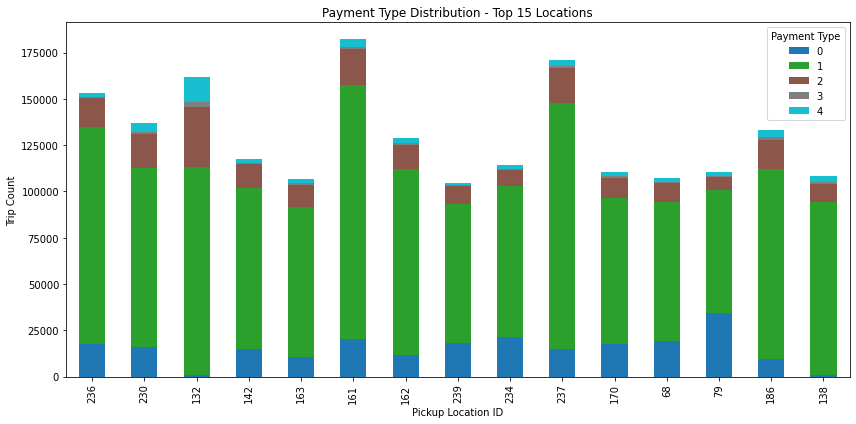

In [0]:
# Step 1: Aggregate total trips per PULocationID
top_locations = df.groupBy("PULocationID").count().orderBy("count", ascending=False).limit(15)
top_location_ids = [row['PULocationID'] for row in top_locations.collect()]

# Step 2: Filter original dataframe to only top PULocationIDs
filtered_df = df.filter(df["PULocationID"].isin(top_location_ids))

# Step 3: Group by for pivot
grouped_df = filtered_df.groupBy("PULocationID", "payment_type").count()

# Step 4: Pivot and plot as before
pivot_df = grouped_df.groupBy("PULocationID").pivot("payment_type").sum("count").fillna(0)
pandas_df = pivot_df.toPandas().set_index("PULocationID")

# Plot again
pandas_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab10')
plt.title("Payment Type Distribution - Top 15 Locations")
plt.xlabel("Pickup Location ID")
plt.ylabel("Trip Count")
plt.legend(title="Payment Type")
plt.tight_layout()
plt.show()


b): Single Passenger Trips by Day of Week

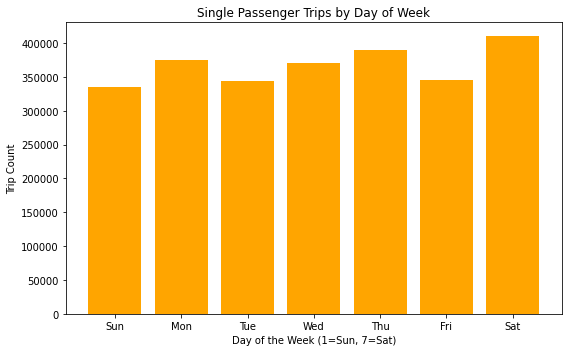

In [0]:
from pyspark.sql.functions import dayofweek, col, count
import matplotlib.pyplot as plt

# Filter for single passenger trips
df_single_passenger = df.filter(col("passenger_count") == 1)

# Extract day of the week
df_by_day = df_single_passenger.withColumn("day_of_week", dayofweek("tpep_pickup_datetime"))

# Count trips per day
trips_by_day = df_by_day.groupBy("day_of_week").agg(count("*").alias("trip_count"))

# Convert to Pandas for plotting
pandas_day_df = trips_by_day.toPandas().sort_values("day_of_week")

# Plotting
plt.figure(figsize=(8,5))
plt.bar(pandas_day_df["day_of_week"], pandas_day_df["trip_count"], color="orange")
plt.xlabel("Day of the Week (1=Sun, 7=Sat)")
plt.ylabel("Trip Count")
plt.title("Single Passenger Trips by Day of Week")
plt.xticks(ticks=range(1,8), labels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.tight_layout()
plt.show()


c) Top 10 Most Profitable Taxi Routes

In [0]:
from pyspark.sql.functions import col, sum

# Group by pickup and drop-off locations, and calculate total fare
top_routes = df.groupBy("PULocationID", "DOLocationID") \
               .agg(sum("fare_amount").alias("total_fare")) \
               .orderBy(col("total_fare").desc()) \
               .limit(10)

top_routes.show()


+------------+------------+------------------+
|PULocationID|DOLocationID|        total_fare|
+------------+------------+------------------+
|         132|         265| 557087.1899999997|
|         132|         230| 440701.3600000001|
|         138|         230| 314046.0300000002|
|         132|         164|256175.54000000004|
|         230|         138|238557.38999999987|
|         132|          48|227633.32000000004|
|         132|         163|212099.62000000002|
|         132|         132|211185.76999999987|
|         230|         132| 201167.3900000001|
|         237|         236|195469.68000000025|
+------------+------------+------------------+



f) Analyse taxi pickup distribution in Manhattan (LocationID 132) and The Bronx (LocationID 138) by:

Hour of day

Day of week
With heatmaps showing demand trends.

 1. Extract hour and day from timestamp

In [0]:
from pyspark.sql.functions import hour, dayofweek

df_time = df.withColumn("hour", hour("tpep_pickup_datetime")) \
            .withColumn("day_of_week", dayofweek("tpep_pickup_datetime"))


2. Filter by boroughs (Manhattan = 132, Bronx = 138)

In [0]:
manhattan_df = df_time.filter(df_time["PULocationID"] == 132)
bronx_df = df_time.filter(df_time["PULocationID"] == 138)


3. Group & count pickups

In [0]:
manhattan_grouped = manhattan_df.groupBy("hour", "day_of_week").count()
bronx_grouped = bronx_df.groupBy("hour", "day_of_week").count()


4. Convert to Pandas for plotting

In [0]:
manhattan_pd = manhattan_grouped.toPandas()
bronx_pd = bronx_grouped.toPandas()


5. Heatmaps

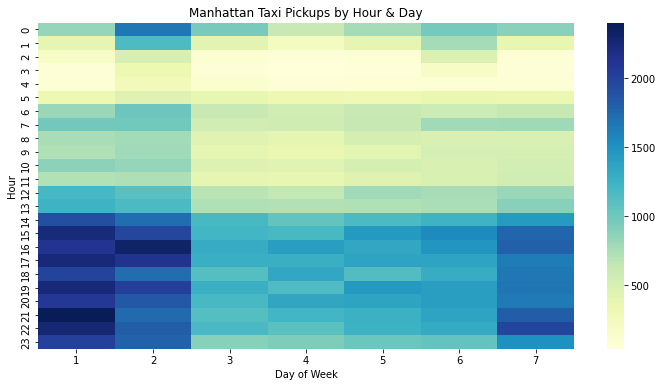

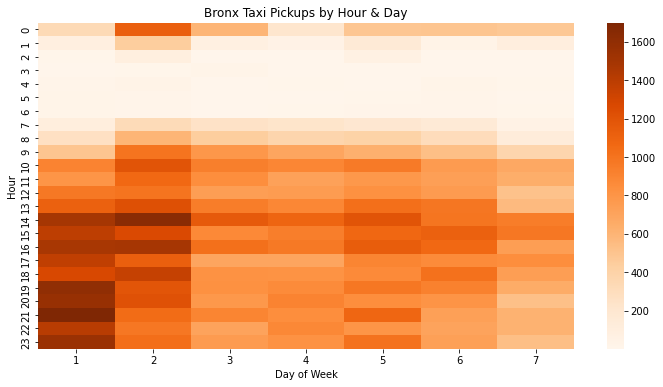

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Manhattan heatmap
pivot_m = manhattan_pd.pivot(index="hour", columns="day_of_week", values="count")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_m, cmap="YlGnBu")
plt.title("Manhattan Taxi Pickups by Hour & Day")
plt.xlabel("Day of Week")
plt.ylabel("Hour")
plt.show()

# Bronx heatmap
pivot_b = bronx_pd.pivot(index="hour", columns="day_of_week", values="count")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_b, cmap="Oranges")
plt.title("Bronx Taxi Pickups by Hour & Day")
plt.xlabel("Day of Week")
plt.ylabel("Hour")
plt.show()
